In [1]:
import os
import sys
import random
import json
import collections
import itertools

import pandas as pd
import numpy as np
import scipy        
import statsmodels


from tqdm import trange, tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 999

sns.set()

plt.rcParams["figure.figsize"] = (10,7)

In [2]:
os.getcwd()

'/home/boris/study/UT study/ACM Sigmod/sigmod/notebooks'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from sigmod_src.utils import read_json, pprint_json, path_from_spec_id, get_vector_for_spec_id
from sigmod_src.data.embedding import get_embedder, emb_lookup

# Load data

In [5]:
labelled_dataset_path = '../data/processed/labelled_features.csv'

In [6]:
df = pd.read_csv(labelled_dataset_path)

In [7]:
df.shape

(46665, 2005)

In [8]:
df.head()

,left_spec_id,right_spec_id,label,left_page_title_stem__00,left_page_title_stem__013803117493,left_page_title_stem__0mp,left_page_title_stem__10,left_page_title_stem__10 30mm,left_page_title_stem__10 cctv,left_page_title_stem__10 mp,left_page_title_stem__100,left_page_title_stem__105mm,left_page_title_stem__1080p,left_page_title_stem__1080p hd,left_page_title_stem__1080p ip,left_page_title_stem__10mp,left_page_title_stem__10mp digit,left_page_title_stem__10x,left_page_title_stem__1100d,left_page_title_stem__12,left_page_title_stem__12 1mp,left_page_title_stem__12 megapixel,left_page_title_stem__12 mp,left_page_title_stem__12mp,left_page_title_stem__135,left_page_title_stem__135mm,left_page_title_stem__14,left_page_title_stem__14 42mm,left_page_title_stem__14 mp,left_page_title_stem__14mp,left_page_title_stem__15,left_page_title_stem__16,left_page_title_stem__16 1mp,left_page_title_stem__16 2mp,left_page_title_stem__16 50mm,left_page_title_stem__16 megapixel,left_page_title_stem__16 mp,left_page_title_stem__16gb,left_page_title_stem__16mp,left_page_title_stem__16mp digit,left_page_title_stem__16x,left_page_title_stem__18,left_page_title_stem__18 135mm,left_page_title_stem__18 55,left_page_title_stem__18 55mm,left_page_title_stem__18 mp,left_page_title_stem__18mp,left_page_title_stem__1d,left_page_title_stem__1mp,left_page_title_stem__1mp digit,left_page_title_stem__20,left_page_title_stem__20 mp,left_page_title_stem__200,left_page_title_stem__200mm,left_page_title_stem__2013,left_page_title_stem__2014,left_page_title_stem__2014 new,left_page_title_stem__2014 spec,left_page_title_stem__20x,left_page_title_stem__20x optic,left_page_title_stem__21,left_page_title_stem__24,left_page_title_stem__24 mp,left_page_title_stem__264,left_page_title_stem__28,left_page_title_stem__2cd2012,left_page_title_stem__2cd2032,left_page_title_stem__2cd2112,left_page_title_stem__2cd2112 buy,left_page_title_stem__2cd2132,left_page_title_stem__2cd2212,left_page_title_stem__2cd2212 i5,left_page_title_stem__2cd2232,left_page_title_stem__2cd2232 i5,left_page_title_stem__2cd2332,left_page_title_stem__2cd2532f,left_page_title_stem__2cd2632f,left_page_title_stem__2cd2632f is,left_page_title_stem__2cd3332,left_page_title_stem__2cd3332 hikvis,left_page_title_stem__2mp,left_page_title_stem__2mp digit,left_page_title_stem__30,left_page_title_stem__300,left_page_title_stem__300mm,left_page_title_stem__30m,left_page_title_stem__30mm,left_page_title_stem__30x,left_page_title_stem__32gb,left_page_title_stem__36,left_page_title_stem__3d,left_page_title_stem__3g,left_page_title_stem__3megapixel,left_page_title_stem__3mp,left_page_title_stem__3mp ds,left_page_title_stem__3mp ir,left_page_title_stem__3x,left_page_title_stem__3x optic,left_page_title_stem__40,left_page_title_stem__42,left_page_title_stem__42mm,left_page_title_stem__4x,left_page_title_stem__50,left_page_title_stem__50mm,left_page_title_stem__50mm len,left_page_title_stem__55,left_page_title_stem__55 mm,left_page_title_stem__55mm,left_page_title_stem__55mm is,left_page_title_stem__55mm len,left_page_title_stem__55mm vr,left_page_title_stem__5d,left_page_title_stem__5d mark,left_page_title_stem__5mp,left_page_title_stem__5x,left_page_title_stem__5x optic,left_page_title_stem__600d,left_page_title_stem__600d 18,left_page_title_stem__60d,left_page_title_stem__6d,left_page_title_stem__70,left_page_title_stem__700tvl,left_page_title_stem__70d,left_page_title_stem__720p,left_page_title_stem__720p hd,left_page_title_stem__720p ip,left_page_title_stem__75,left_page_title_stem__7d,left_page_title_stem__7d 18,left_page_title_stem__8gb,left_page_title_stem__8x,left_page_title_stem__90,left_page_title_stem__95,left_page_title_stem__99,left_page_title_stem__accessori,left_page_title_stem__action,left_page_title_stem__action camera,left_page_title_stem__af,left_page_title_stem__af dx,left_page_title_stem__ahd,left_page_title_stem__ahd camera,left_page_title_stem__ahmedabad,left_page_title_stem__ahmedabad surat,left_page

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46665 entries, 0 to 46664
Columns: 2005 entries, left_spec_id to right_site_enc
dtypes: float64(2000), int64(3), object(2)
memory usage: 713.8+ MB


# Load embedder and index

In [10]:
from gensim.models import Doc2Vec
from gensim.similarities.index import AnnoyIndexer

In [11]:
emb = Doc2Vec.load('../models/embedder.gensim') 

In [12]:
indexer = AnnoyIndexer()
indexer.load('../models/indexer.annoy')
indexer.model = emb

/home/boris/anaconda3/lib/python3.6/site-packages/gensim/similarities/index.py:159: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  self.index = AnnoyIndex(d['f'])


# Obtain train/test split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X = df.drop(['label', 'left_spec_id', 'right_spec_id'], axis=1)
Y = df.label

In [15]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, stratify=Y)
train_Y.shape, test_Y.shape

((34998,), (11667,))

In [16]:
train_X.shape, test_X.shape

((34998, 2002), (11667, 2002))

# LGB

In [17]:
from lightgbm import LGBMClassifier

In [18]:
from sklearn.metrics import f1_score, plot_confusion_matrix, classification_report

In [19]:
train_Y.value_counts()

0    32312
1     2686
Name: label, dtype: int64

In [20]:
test_Y.value_counts()

0    10771
1      896
Name: label, dtype: int64

In [21]:
sample_pos_weight = Y.value_counts()[0] / Y.value_counts()[1]

In [22]:
clf = LGBMClassifier(sample_pos_weight=sample_pos_weight)

In [23]:
clf.fit(train_X, train_Y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0,
               sample_pos_weight=12.027638190954773, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=1)

In [24]:
pred_train_Y = clf.predict(train_X)

In [25]:
print('Train F1', f1_score(train_Y, pred_train_Y))
print(classification_report(train_Y, pred_train_Y))

Train F1 0.9947604790419161
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32312
           1       1.00      0.99      0.99      2686

    accuracy                           1.00     34998
   macro avg       1.00      0.99      1.00     34998
weighted avg       1.00      1.00      1.00     34998



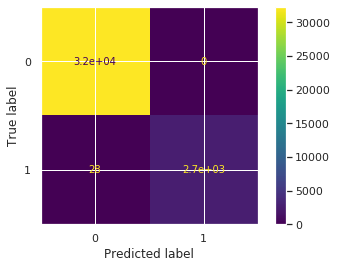

In [26]:
plot_confusion_matrix(clf, train_X, train_Y)

In [27]:
pred_test_Y = clf.predict(test_X)

In [28]:
print('Test F1', f1_score(test_Y, pred_test_Y))
print(classification_report(test_Y, pred_test_Y))

Test F1 0.9771949828962373
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10771
           1       1.00      0.96      0.98       896

    accuracy                           1.00     11667
   macro avg       1.00      0.98      0.99     11667
weighted avg       1.00      1.00      1.00     11667



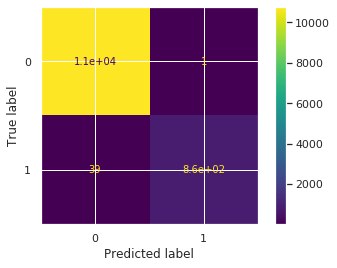

In [29]:
plot_confusion_matrix(clf, test_X, test_Y)

# Feature importance

In [30]:
import shap

In [31]:
explainer = shap.TreeExplainer(clf)

In [32]:
shap_values = explainer.shap_values(train_X)

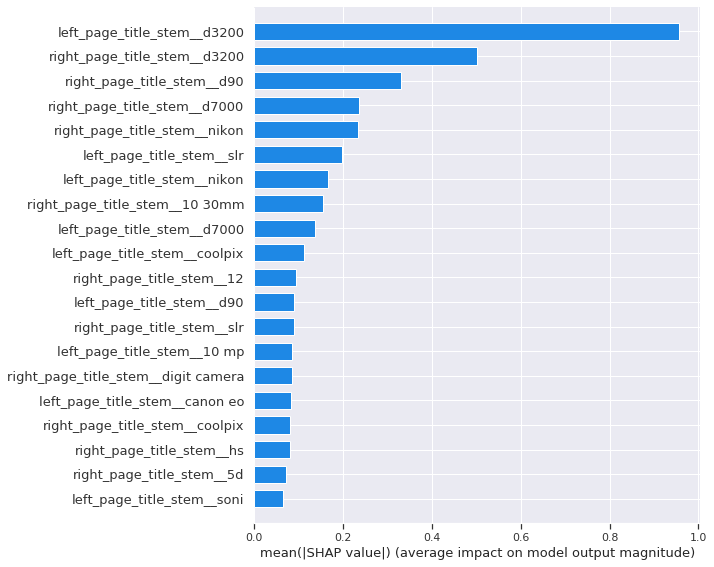

In [33]:
shap.summary_plot(shap_values, train_X, plot_type="bar")

# Load specs df

In [34]:
specs_df = pd.read_csv('../data/processed/specs_features.csv')
specs_df.index=  specs_df.spec_id
specs_df.shape

(29787, 1006)

In [58]:
specs_df = specs_df[~specs_df.page_title.isnull()]
specs_df.shape

(29783, 1006)

In [59]:
specs_df.head()

,spec_id,page_title,page_title_stem,brand,site,page_title_stem__00,page_title_stem__013803117493,page_title_stem__0mp,page_title_stem__10,page_title_stem__10 30mm,page_title_stem__10 cctv,page_title_stem__10 mp,page_title_stem__100,page_title_stem__105mm,page_title_stem__1080p,page_title_stem__1080p hd,page_title_stem__1080p ip,page_title_stem__10mp,page_title_stem__10mp digit,page_title_stem__10x,page_title_stem__1100d,page_title_stem__12,page_title_stem__12 1mp,page_title_stem__12 megapixel,page_title_stem__12 mp,page_title_stem__12mp,page_title_stem__135,page_title_stem__135mm,page_title_stem__14,page_title_stem__14 42mm,page_title_stem__14 mp,page_title_stem__14mp,page_title_stem__15,page_title_stem__16,page_title_stem__16 1mp,page_title_stem__16 2mp,page_title_stem__16 50mm,page_title_stem__16 megapixel,page_title_stem__16 mp,page_title_stem__16gb,page_title_stem__16mp,page_title_stem__16mp digit,page_title_stem__16x,page_title_stem__18,page_title_stem__18 135mm,page_title_stem__18 55,page_title_stem__18 55mm,page_title_stem__18 mp,page_title_stem__18mp,page_title_stem__1d,page_title_stem__1mp,page_title_stem__1mp digit,page_title_stem__20,page_title_stem__20 mp,page_title_stem__200,page_title_stem__200mm,page_title_stem__2013,page_title_stem__2014,page_title_stem__2014 new,page_title_stem__2014 spec,page_title_stem__20x,page_title_stem__20x optic,page_title_stem__21,page_title_stem__24,page_title_stem__24 mp,page_title_stem__264,page_title_stem__28,page_title_stem__2cd2012,page_title_stem__2cd2032,page_title_stem__2cd2112,page_title_stem__2cd2112 buy,page_title_stem__2cd2132,page_title_stem__2cd2212,page_title_stem__2cd2212 i5,page_title_stem__2cd2232,page_title_stem__2cd2232 i5,page_title_stem__2cd2332,page_title_stem__2cd2532f,page_title_stem__2cd2632f,page_title_stem__2cd2632f is,page_title_stem__2cd3332,page_title_stem__2cd3332 hikvis,page_title_stem__2mp,page_title_stem__2mp digit,page_title_stem__30,page_title_stem__300,page_title_stem__300mm,page_title_stem__30m,page_title_stem__30mm,page_title_stem__30x,page_title_stem__32gb,page_title_stem__36,page_title_stem__3d,page_title_stem__3g,page_title_stem__3megapixel,page_title_stem__3mp,page_title_stem__3mp ds,page_title_stem__3mp ir,page_title_stem__3x,page_title_stem__3x optic,page_title_stem__40,page_title_stem__42,page_title_stem__42mm,page_title_stem__4x,page_title_stem__50,page_title_stem__50mm,page_title_stem__50mm len,page_title_stem__55,page_title_stem__55 mm,page_title_stem__55mm,page_title_stem__55mm is,page_title_stem__55mm len,page_title_stem__55mm vr,page_title_stem__5d,page_title_stem__5d mark,page_title_stem__5mp,page_title_stem__5x,page_title_stem__5x optic,page_title_stem__600d,page_title_stem__600d 18,page_title_stem__60d,page_title_stem__6d,page_title_stem__70,page_title_stem__700tvl,page_title_stem__70d,page_title_stem__720p,page_title_stem__720p hd,page_title_stem__720p ip,page_title_stem__75,page_title_stem__7d,page_title_stem__7d 18,page_title_stem__8gb,page_title_stem__8x,page_title_stem__90,page_title_stem__95,page_title_stem__99,page_title_stem__accessori,page_title_stem__action,page_title_stem__action camera,page_title_stem__af,page_title_stem__af dx,page_title_stem__ahd,page_title_stem__ahd camera,page_title_stem__ahmedabad,page_title_stem__ahmedabad surat,page_title_stem__alarm,page_title_stem__alibaba,page_title_stem__alibaba com,page_title_stem__alpha,page_title_stem__alpha nex,page_title_stem__alpha slt,page_title_stem__aluminum,page_title_stem__analog,page_title_stem__and,page_title_stem__and ixus,page_title_stem__and review,page_title_stem__android,page_title_stem__angl,page_title_stem__as,page_title_stem__at,page_title_stem__at buy,page_title_stem__at pc,page_title_stem__australia,page_title_stem__auto,page_title_stem__backpack,page_title_stem__bag,page_title_stem__bag buy,page_title_stem__bag camera,page_title_stem__bag case,page_title_stem__bag digit,page_title_stem__bag dslr,page_title_stem__bag for,page_title_stem__bag product,p

In [60]:
spec_feature_names = set(specs_df.columns).difference(['page_title', 'page_title_stem', 'brand', 'site'])
len(spec_feature_names)

1002

# Submit

## Train on whole train data

In [61]:
del train_X
del test_X
del train_Y
del test_Y

NameError: name 'train_X' is not defined

In [62]:
clf.fit(X, Y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0,
               sample_pos_weight=12.027638190954773, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=1)

## Generate submit

In [63]:
clf_column_order = df.drop(['label'], axis=1).columns
clf_column_order

Index(['left_spec_id', 'right_spec_id', 'left_page_title_stem__00',
       'left_page_title_stem__013803117493', 'left_page_title_stem__0mp',
       'left_page_title_stem__10', 'left_page_title_stem__10 30mm',
       'left_page_title_stem__10 cctv', 'left_page_title_stem__10 mp',
       'left_page_title_stem__100',
       ...
       'right_page_title_stem__work', 'right_page_title_stem__zealand',
       'right_page_title_stem__zealand price', 'right_page_title_stem__zoom',
       'right_page_title_stem__zoom black', 'right_page_title_stem__zoom buy',
       'right_page_title_stem__zoom digit', 'right_page_title_stem__zoom len',
       'right_page_title_stem__zoom mp', 'right_site_enc'],
      dtype='object', length=2004)

In [64]:
OUT_FILE_PATH = '../data/submit/submit.csv'

if os.path.exists(OUT_FILE_PATH):
    os.remove(OUT_FILE_PATH)

In [65]:
buffer_size = 10000

In [66]:
def get_candidate_specs(query_text, emb, indexer):
    nns = emb_lookup(query_text, emb, indexer, n=30)
    nn_spec_ids = [nn[0] for nn in nns]
    return nn_spec_ids

def predict_duplicates(clf, chunk_df):
    X = chunk_df.drop(['left_spec_id', 'right_spec_id'], axis=1)
    predicted_label = clf.predict(X)
    return predicted_label

def write_chunk_df(chunk_df):
    out_df = chunk_df[chunk_df.label == 1][['left_spec_id', 'right_spec_id']]
    if not out_df.empty:
        if os.path.exists(OUT_FILE_PATH):
            out_df.to_csv(OUT_FILE_PATH, mode='a', header=False, index=False)
        else:
            out_df.to_csv(OUT_FILE_PATH, index=False)

        print('Wrote ', out_df.shape[0], ' dupliates to disk')

def process_buffered_rows(row_buffer):
    row_columns = ['left_'+col for col in spec_feature_names]+['right_'+col for col in spec_feature_names]
    chunk_df = pd.DataFrame(row_buffer, columns=row_columns)
    chunk_df = chunk_df[clf_column_order]
    chunk_df['label'] = predict_duplicates(clf, chunk_df) 
    write_chunk_df(chunk_df)

In [ ]:
row_buffer = []
for left_index, spec_row in tqdm(specs_df.iterrows()):
    left_spec_id = spec_row.spec_id
    candidates = get_candidate_specs(spec_row.page_title_stem, emb, indexer)
    for right_spec_id in candidates:
        if left_spec_id == right_spec_id:
            continue
        
        left_brand = specs_df.loc[left_spec_id].brand
        right_brand = specs_df.loc[right_spec_id].brand
        
        # Different brands, so we can just skip it
        if ((left_brand is not None) and (right_brand is not None) and (left_brand != right_brand)):
            continue
    
        left_row = specs_df.loc[left_spec_id][spec_feature_names]
        right_row = specs_df.loc[right_spec_id][spec_feature_names]
        features_row = np.concatenate([left_row.values, right_row.values])
        row_buffer.append(features_row)
    
    if len(row_buffer) >= buffer_size:
        process_buffered_rows(row_buffer)  
        row_buffer = []

if row_buffer:
    process_buffered_rows(row_buffer)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Wrote  1676  dupliates to disk


In [290]:
submit_df = pd.read_csv('../data/submit/submit.csv')

In [291]:
submit_df.head()

,left_spec_id,right_spec_id
0,www.ebay.com//60583,cammarkt.com//513
1,www.ebay.com//60583,cammarkt.com//78
2,www.ebay.com//60583,www.ebay.com//58614
3,www.ebay.com//60583,www.ebay.com//54524
4,www.ebay.com//60583,www.ebay.com//59924


In [292]:
submit_df.shape

(42812, 2)